# Notebook for Conversion from JPEGs to TFRecords with feature and labels. Notebook (1/4) in the End-to-End Scalable Deep Learning Pipeline on Hops.

TinyImageNet dataset contains a training set of 100,000 images, a validation set of 10,000 images, and a test
set of also 10,000 images. These images are sourced from 200 different classes of objects. The images are downscaled from the original ImageNet’s dataset size of 256x256 to 64x64. 

The two initial tasks before we can train a model on this dataset are:

1. Group the images with their labels 
2. Convert the JPEGs into TFRecords

When using large datasets, like ImageNet, dealing with JPEGs is not very efficient, nor compatible with all of the functionality in the Tensorflow framework. 

TFRecords is a binary format for representing features and labels in Tensoflow, using a binary format for a large dataset can have a huge impact on disk space and processing speed. In addition, TFRecords are easier to work with than working with the raw JPEGs. 

However, TFRecords is not very friendly to query and analyze, so we can also store the feature data as Hive tables in the feature store.

![step1.png](../images/step1.png)

This notebook read JPEGs and labels from:

- hdfs:///Projects/ImageNet_EndToEnd_MLPipeline/tiny-imagenet/tiny-imagenet-200/train
- hdfs:///Projects/ImageNet_EndToEnd_MLPipeline/tiny-imagenet/tiny-imagenet-200/val
- hdfs:///Projects/ImageNet_EndToEnd_MLPipeline/tiny-imagenet/tiny-imagenet-200/test

and dataset metadata from:

- hdfs:///Projects/ImageNet_EndToEnd_MLPipeline/tiny-imagenet/tiny-imagenet-200/words.txt
- hdfs:///Projects/ImageNet_EndToEnd_MLPipeline/tiny-imagenet/tiny-imagenet-200/val/val_annotations.txt

The notebook outputs feature groups (Hive ORC tables):

- train
- test
- val

The notebook outputs the following feature store training datasets (TFRecord files):

- train_dataset_tinyimagenet
- test_dataset_tinyimagenet
- val_dataset_tinyimagenet

To run this notebook you must have installed matplotlib in addition to the libraries available in the base conda environment (python 3.6 recommended as 2.7 will be deprecated soon)

## Package Imports

In [1]:
import tensorflow as tf
import pydoop.hdfs as py_hdfs
from hops import hdfs
import numpy as np
from hops import featurestore
from pyspark.sql.functions import lit
from functools import reduce
from pyspark.sql import DataFrame, Row
import re

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1378,application_1553861944920_0373,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


In [2]:
%%local
import matplotlib.pyplot as plt
import tensorflow as tf
from hops import hdfs

## Constants

In [3]:
PROJECT_DIR = hdfs.project_path()
SHARED_DATASET = "hdfs://10.0.104.196:8020/Projects/ImageNet_EndToEnd_MLPipeline/tiny-imagenet/tiny-imagenet-200/"
TRAIN_DIR = SHARED_DATASET + "train"
TEST_DIR = SHARED_DATASET + "test"
VAL_DIR = SHARED_DATASET + "val/images/"
ID_TO_CLASS_FILE = SHARED_DATASET + "/words.txt"
VAL_LABELS_FILE = SHARED_DATASET + "val/val_annotations.txt"
FILE_PATTERN = "*.JPEG"
SIZES_FILE = PROJECT_DIR + "Resources/sizes.txt"
TRAIN_FEATUREGROUP = "train_tinyimagenet"
TRAIN_FEATUREGROUP_VERSION = 1
TEST_FEATUREGROUP = "test_tinyimagenet"
TEST_FEATUREGROUP_VERSION = 1
VAL_FEATUREGROUP = "val_tinyimagenet"
VAL_FEATUREGROUP_VERSION = 1
TRAIN_DATASET = "train_dataset_tinyimagenet"
TEST_DATASET = "test_dataset_tinyimagenet"
VAL_DATASET = "val_dataset_tinyimagenet"
HEIGHT = 64
WIDTH = 64
CHANNELS = 3

Define constants in %%local environment as well, for plotting and data analysis

In [4]:
%%local
PROJECT_DIR = hdfs.project_path()
SHARED_DATASET = "hdfs://10.0.104.196:8020/Projects/ImageNet_EndToEnd_MLPipeline/tiny-imagenet/tiny-imagenet-200/"
TRAIN_DIR = SHARED_DATASET + "train"
TEST_DIR = SHARED_DATASET + "test"
VAL_DIR = SHARED_DATASET + "val/images/"
ID_TO_CLASS_FILE = SHARED_DATASET + "/words.txt"
VAL_LABELS_FILE = SHARED_DATASET + "val/val_annotations.txt"
FILE_PATTERN = "*.JPEG"
SIZES_FILE = PROJECT_DIR + "Resources/sizes.txt"
TRAIN_FEATUREGROUP = "train_tinyimagenet"
TRAIN_FEATUREGROUP_VERSION = 1
TEST_FEATUREGROUP = "test_tinyimagenet"
TEST_FEATUREGROUP_VERSION = 1
VAL_FEATUREGROUP = "val_tinyimagenet"
VAL_FEATUREGROUP_VERSION = 1
TRAIN_DATASET = "train_dataset_tinyimagenet"
TEST_DATASET = "test_dataset_tinyimagenet"
VAL_DATASET = "val_dataset_tinyimagenet"
HEIGHT = 64
WIDTH = 64
CHANNELS = 3

## Data Exploration

We can inspect some sample images from the dataset. Since Tensorflow support HDFS as a data source, we can use Tensorflow for reading from HDFS and then plot the images with matplotlib.

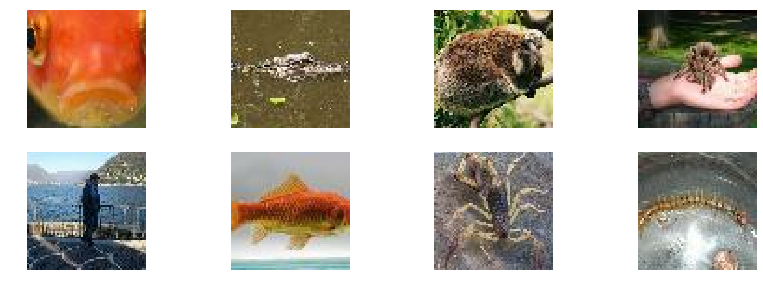

In [8]:
%%local
%matplotlib inline
base_path = "hdfs://10.0.104.196:8020/Projects/ImageNet_EndToEnd_MLPipeline/tiny-imagenet/tiny-imagenet-200/train"
sample_images = [
    base_path + "/n01443537/images/n01443537_327.JPEG",
    base_path + "/n01698640/images/n01698640_381.JPEG",
    base_path + "/n01882714/images/n01882714_300.JPEG",
    base_path + "/n01774750/images/n01774750_24.JPEG",
    base_path + "/n09332890/images/n09332890_300.JPEG",
    base_path + "/n01443537/images/n01443537_328.JPEG",
    base_path + "/n01770393/images/n01770393_101.JPEG",
    base_path + "/n01784675/images/n01784675_101.JPEG"
]
img_op_0 = tf.image.decode_jpeg(tf.read_file(sample_images[0]))
img_op_1 = tf.image.decode_jpeg(tf.read_file(sample_images[1]))
img_op_2 = tf.image.decode_jpeg(tf.read_file(sample_images[2]))
img_op_3 = tf.image.decode_jpeg(tf.read_file(sample_images[3]))
img_op_4 = tf.image.decode_jpeg(tf.read_file(sample_images[4]))
img_op_5 = tf.image.decode_jpeg(tf.read_file(sample_images[5]))
img_op_6 = tf.image.decode_jpeg(tf.read_file(sample_images[6]))
img_op_7 = tf.image.decode_jpeg(tf.read_file(sample_images[7]))
sample_images_parsed = []
with tf.Session() as sess:
    sample_images_parsed.append(img_op_0.eval())
    sample_images_parsed.append(img_op_1.eval())
    sample_images_parsed.append(img_op_2.eval())
    sample_images_parsed.append(img_op_3.eval())
    sample_images_parsed.append(img_op_4.eval())
    sample_images_parsed.append(img_op_5.eval())
    sample_images_parsed.append(img_op_6.eval())
    sample_images_parsed.append(img_op_7.eval())

plt.rcParams["figure.figsize"] = (14,10)
count = 0
for img in sample_images_parsed:
    count += 1
    plt.subplot(4,4,count)
    plt.imshow(img)
    plt.axis("off")
plt.show()

Lets look at the class distribution in the train set

In [9]:
%%local
# this will take 1-2 minutes
number_of_examples_per_class = list(map(lambda d: len(hdfs.ls(d + "/images/")), hdfs.ls(TRAIN_DIR)))

As we can see, the examples are uniformly distributed over the classes. In the training dataset there are 200 classes with 500 examples in each (total 100 000 images in the training dataset)

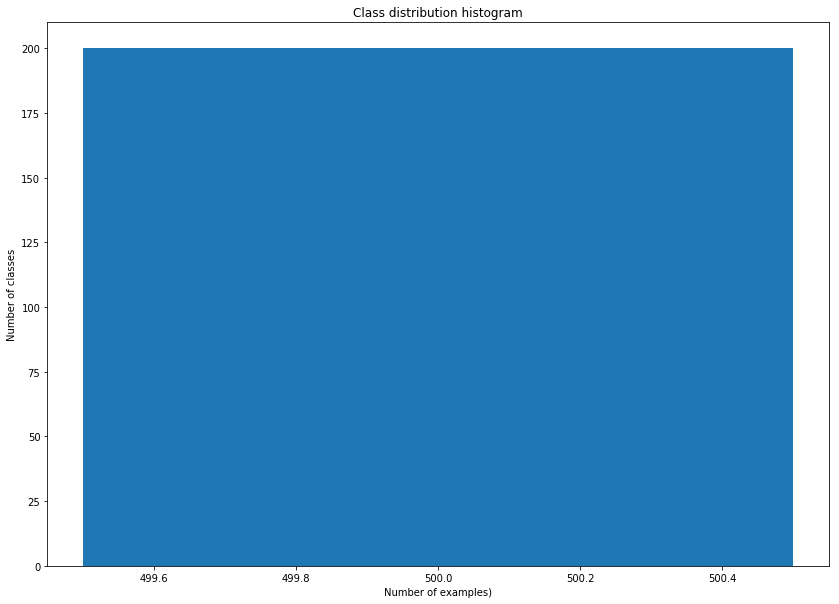

In [10]:
%%local
plt.hist(number_of_examples_per_class, bins='auto')
plt.xlabel('Number of examples)')
plt.ylabel('Number of classes')
plt.title('Class distribution histogram')
plt.savefig("class_distribution.png")
plt.show()

## Parse Metadata about the Dataset

The dataset has some .txt files with annotation and other metadata that needs to be parsed. This metadata for example explains what the label for the image directories are.

In [23]:
def parse_metadata():
    """ 
    Parses the words.txt file into a map of label -> words and a list of ordered nids (index of nid = integer label).
    Also parses the val_annotations.txt file into a map of (validation_file_name --> nid)
    """
    # list all directories in the train set, the directory name is the "nid" and identifies the label
    train_dirs = py_hdfs.ls(TRAIN_DIR)
    
    # remove the path except the nid
    train_nid_list = list(map(lambda x: x.replace(TRAIN_DIR + "/", ""), train_dirs))
    
    # the number of nids equal the number of unique classes/labels
    num_classes = len(train_nid_list)
    
    # read the words.txt file that contains lines of the form "nid\words"
    with py_hdfs.open(ID_TO_CLASS_FILE, 'r') as f:
        file_lines = f.read().decode("utf-8").split("\n")
    label_to_word = {}
    
    for l in file_lines:
        # parse each line
        wnid, word = l.split('\t')
        if wnid in train_nid_list:
            # convert the nids into integer labels by using the position in the index
            label = train_nid_list.index(wnid)
            word = str(label) + ": " + word
            # save the mapping of integer label --> words
            label_to_word[label] = word
    
    # read the val_annotations.txt file that contains lines of the form: 
    # "validation_image\tnid\tx_pos\ty_pos\tw_pos\th_pos"
    with py_hdfs.open(VAL_LABELS_FILE, 'r') as f:
        file_lines = f.read().decode("utf-8").split("\n")
    validation_file_to_nid = {}
    for l in file_lines:
        # parse each line
        tokens = l.split('\t')
        #skip corrupted lines
        if len(tokens) > 2:
            validation_img = tokens[0]
            wnid = tokens[1]
            # we only care about classification in this tutorial, not localization 
            if wnid in train_nid_list:
                validation_file_to_nid[validation_img] = wnid
    
    return train_nid_list, label_to_word, validation_file_to_nid

## Insert Training Data to the Feature Store as a Feature Group

The training data is split into several directories, we need to join them together before we can put them in the featurestore.

In [24]:
def filter_shapes(row):
    """
    Filter to remove images of wrong shape. 
    2% of the tinyimagenet images are not colored, while the rest are, this filter will simply drop
    the non-colored images.
    
    Args:
          :row: a row from a spark dataframe containing images
    
    Returns:
           True if the image matches the expected dimensions, False otherwise
          
    """
    try:
        image = row.image
        height = image.height
        width = image.width
        nChannels = image.nChannels
        if height != HEIGHT or width != WIDTH or nChannels != CHANNELS:
            return False
        else:
            return True
    except:
        return False

In [25]:
def insert_train_dirs_into_featurestore():
    """
    Loops over all directories with training data and inserts them into the featurestore.
    There are 500 images in each directory, the name of the directory indicates the label of the images.
    
    Inserts the training data into the featurestore as a feature group (Hive table) with schema:
    
    |image|label|
    """
    # Make sure feature store metadata is up to date
    featurestore.get_featurestore_metadata(update_cache=True)
    # Parse TinyImageNet metadata file from HopsFS
    nid_list, label_to_word, validation_file_to_nid = parse_metadata()
    # Read the train dir from HopsFS into a spark image dataframe
    train_dir = TRAIN_DIR + "/*/images/"
    image_df = spark.read.format("image").load(train_dir)
    # Filter out images with wrong dimensions
    image_df_filtered = image_df.rdd.filter(filter_shapes).toDF()
    # Add the label to each image file (label can be inferred using the nid_list and the image file name)
    def map_label(row):
        Example = Row("image", "label")
        filename = row.image.origin
        # Extract label from the file name and the nid_list
        label = nid_list.index(re.sub("[^images]*$", "", filename.replace(TRAIN_DIR, "").replace("/", "")).replace("images",""))
        return Example(row.image, label)
    features_df = image_df_filtered.rdd.map(map_label).toDF()
    featurestore.create_featuregroup(features_df, TRAIN_FEATUREGROUP, 
                                     description="train data for image classification with TinyImageNet, contains labelled train images",
                                     feature_correlation=False, 
                                     cluster_analysis=False,
                                    feature_histograms=False,
                                    descriptive_statistics=True,
                                    featuregroup_version=TRAIN_FEATUREGROUP_VERSION
                                    )

## Insert Testing Data to the Feature Store as a Feature Group

In [26]:
def insert_test_dir_into_featurestore():
    """
    Reads a single directory of images from HopsFS and inserts it into 
    the featurestore as a feature group (Hive table) with schema:
    
    |image|
    """
    test_dir = TEST_DIR + "/images/"
    # Read the train dir from HopsFS into a spark image dataframe
    image_df = spark.read.format("image").load(test_dir)
    # Filter out images with wrong dimensions
    image_df_filtered = image_df.rdd.filter(filter_shapes).toDF()
    # Insert into feature store as a feature group
    featurestore.create_featuregroup(image_df_filtered, TEST_FEATUREGROUP, 
                                     description = "test data for image classification with TinyImageNet, contains unlabelled test images",
                                     feature_correlation=False, 
                                     cluster_analysis=False, feature_histograms=False,
                                     descriptive_statistics=True, 
                                     featuregroup_version=TEST_FEATUREGROUP_VERSION)

## Insert Validation Data to the Feature Store as a Feature Group

In [27]:
def insert_val_dir_into_featurestore():
    """
    Reads a single directory of images from HopsFS and inserts it into 
    the featurestore as a feature group (Hive table) with schema:
    
    |image|label|
    """
    # Parse TinyImageNet metadata file from HopsFS
    nid_list, label_to_word, validation_file_to_nid = parse_metadata()
    # Read the train dir from HopsFS into a spark image dataframe
    val_dir = VAL_DIR
    image_df = spark.read.format("image").load(val_dir)
    # Filter out images with wrong dimensions
    image_df_filtered = image_df.rdd.filter(filter_shapes).toDF()
    # Add the label to each image file (label can be inferred using the nid_list and the image file name)
    def map_label(row):
        Example = Row("image", "label")
        filename = row.image.origin
        label = nid_list.index(validation_file_to_nid[filename.replace(VAL_DIR, "")])
        return Example(row.image, label)
    features_df = image_df_filtered.rdd.map(map_label).toDF()
    # Insert into feature store as a feature group
    featurestore.create_featuregroup(features_df, VAL_FEATUREGROUP, 
                                     description = "validation data for image classification with TinyImageNet, contains labelled images",
                                     feature_correlation=False, 
                                     cluster_analysis=False, feature_histograms=False,
                                     descriptive_statistics=True, 
                                     featuregroup_version=VAL_FEATUREGROUP_VERSION)

## Run The Pipeline

1. Insert training data in the feature store as a feature group
2. Insert test data in the feature store as a feature group
3. Insert validation data in the feature store as a feature group


In [12]:
insert_train_dirs_into_featurestore()

computing descriptive statistics for : train_tinyimagenet
Running sql: use endtoendv2_featurestore
Feature group created successfully

In [13]:
insert_test_dir_into_featurestore()

computing descriptive statistics for : test_tinyimagenet
Running sql: use endtoendv2_featurestore
Feature group created successfully

In [14]:
insert_val_dir_into_featurestore()

computing descriptive statistics for : val_tinyimagenet
Running sql: use endtoendv2_featurestore
Feature group created successfully

Now we have three feature groups in the feature store stored in ORC rather than a directory with tons of JPEGs and attached metadata. 

- train_tinyimagenet
- test_tinyimagenet
- val_tinyimagenet

## Verify The Results

TinyImageNet dataset contains a training set of 100,000 images, a validation set of 10,000 images, and a test set of also 10,000 images. These images are sourced from 200 different classes of objects. The images are downscaled from the original ImageNet’s dataset size of 256x256 to 64x64. 

2% of the images are grey-scaled and the rest are colored. We have filtered out the grey scaled images, so the counts should be slightly lower than 100,000, 10,000, and 10,000. The dimensions should be 64x64x3 since the images are colored.

In [15]:
featurestore.get_featuregroup(TRAIN_FEATUREGROUP).count()

Running sql: use endtoendv2_featurestore
Running sql: SELECT * FROM train_tinyimagenet_1
98179

In [16]:
featurestore.get_featuregroup(VAL_FEATUREGROUP).count()

Running sql: use endtoendv2_featurestore
Running sql: SELECT * FROM val_tinyimagenet_1
9832

In [17]:
featurestore.get_featuregroup(TEST_FEATUREGROUP).count()

Running sql: use endtoendv2_featurestore
Running sql: SELECT * FROM test_tinyimagenet_1
9811

## Create Training Datasets

We can now take the feature groups in the feature store and convert them into training datasets in a suitable format. TFRecords is the recommended format when using Tensorflow.

In [14]:
def to_np_array(image):
    """
    Converts a spark image representation to a numpy array
    
    Args:
        :image: the image to convert
    
    Returns:
            A multi-dimensional numpy array representing the image
    """
    height = image.height
    width = image.width
    nChannels = image.nChannels
    return np.ndarray(
        shape=(height, width, nChannels),
        dtype=np.uint8,
        buffer=image.data,
        strides=(width * nChannels, nChannels, 1)).astype(np.int64)

In [28]:
def create_train_dataset():
    """
    Creates a tfrecords dataset in the feature store, containing the train images and labels
    """
    # Read images from feature store (ORC)
    feature_df = featurestore.get_featuregroup(TRAIN_FEATUREGROUP)
    # Convert the image representation to a flattened float array
    def mapper(row):
        Example = Row("image", "label")
        label = row.label # long label
        image = to_np_array(row.image).flatten().tolist() #12288 length array with the image data (64x64x3)
        return Example(image, label)
    feature_df2 = feature_df.rdd.filter(filter_shapes).map(mapper).toDF()
    # Save as a training dataset in TFRecords format in the feature store
    featurestore.create_training_dataset(feature_df2, 
                                         TRAIN_DATASET,
                                         description="training dataset for TinyImageNet Classification, Stored as TFRecords",
                                        data_format="tfrecords",
                                        descriptive_statistics=True,
                                        training_dataset_version=1,
                                        feature_correlation=False, 
                                        cluster_analysis=False, 
                                        feature_histograms=False,
                                        )

In [29]:
def create_test_dataset():
    """
    Creates a tfrecords dataset in the feature store, containing the test images
    """    
    # Read images from feature store (ORC)
    feature_df = featurestore.get_featuregroup(TEST_FEATUREGROUP)
    # Convert the image representation to a flattened float array
    def mapper(row):
        Example = Row("image")
        image = to_np_array(row.image).flatten().tolist() #12288 length array with the image data (64x64x3)
        return Example(image)
    feature_df2 = feature_df.rdd.filter(filter_shapes).map(mapper).toDF()
    # Save as a dataset in TFRecords format in the feature store
    featurestore.create_training_dataset(feature_df2, 
                                         TEST_DATASET,
                                         description="test dataset for TinyImageNet Classification, Stored as TFRecords",
                                        data_format="tfrecords",
                                        descriptive_statistics=True,
                                        training_dataset_version=1,
                                        feature_correlation=False, 
                                        cluster_analysis=False, 
                                        feature_histograms=False,
                                        )

In [30]:
def create_val_dataset():
    """
    Creates a tfrecords dataset in the feature store, containing the validation images and labels
    """
    # Read images from feature store (ORC)
    feature_df = featurestore.get_featuregroup(VAL_FEATUREGROUP)
    # Convert the image representation to a flattened float array
    def mapper(row):
        Example = Row("image", "label")
        label = row.label # long label
        image = to_np_array(row.image).flatten().tolist() #12288 length array with the image data (64x64x3)
        return Example(image, label)
    feature_df2 = feature_df.rdd.filter(filter_shapes).map(mapper).toDF()
    # Save as a training dataset in TFRecords format in the feature store
    featurestore.create_training_dataset(feature_df2, 
                                         VAL_DATASET,
                                         description="validation dataset for TinyImageNet Classification, Stored as TFRecords",
                                        data_format="tfrecords",
                                        descriptive_statistics=True,
                                        training_dataset_version=1,
                                        feature_correlation=False, 
                                        cluster_analysis=False, 
                                        feature_histograms=False,
                                        )

## Run the Pipeline

1. Insert training data in the feature store as a training dataset
2. Insert test data in the feature store as a training dataset
3. Insert validation data in the feature store as a training dataset

In [31]:
create_train_dataset()

Running sql: use endtoendv2_featurestore
Running sql: SELECT * FROM train_tinyimagenet_1
computing descriptive statistics for : train_dataset_tinyimagenet
Training Dataset created successfully

In [32]:
create_test_dataset()

Running sql: use endtoendv2_featurestore
Running sql: SELECT * FROM test_tinyimagenet_1
computing descriptive statistics for : test_dataset_tinyimagenet
Training Dataset created successfully

In [33]:
create_val_dataset()

Running sql: use endtoendv2_featurestore
Running sql: SELECT * FROM val_tinyimagenet_1
computing descriptive statistics for : val_dataset_tinyimagenet
Training Dataset created successfully

## Inspect Training Dataset

We can read the tfrecords from disk and very that we stored the data correctly and that the labels match. Once again, to do plotting we have to use %%local so that it will run the computation on the local machine where we have a display, rather than remotely in the spark driver in the cluster.

In [25]:
featurestore.get_training_dataset_path(TRAIN_DATASET)

'hdfs://10.0.104.196:8020/Projects/EndToEndV2/EndToEndV2_Training_Datasets/train_dataset_tinyimagenet_1/train_dataset_tinyimagenet'

In [26]:
featurestore.get_training_dataset_tf_record_schema(TRAIN_DATASET)

{'image': FixedLenFeature(shape=[12288], dtype=tf.int64, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}

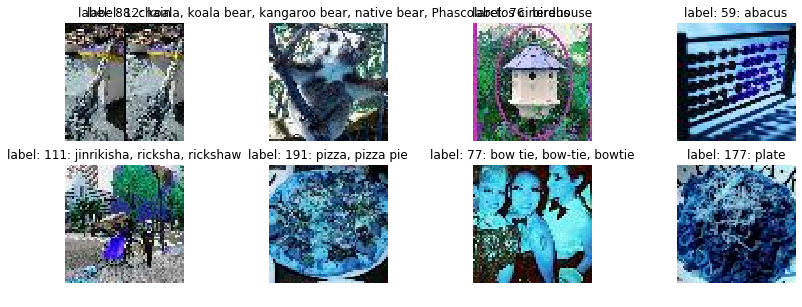

In [27]:
%%local
%matplotlib inline
import pydoop.hdfs as py_hdfs
# We have to redfine this function so that we can use it in the %%local environment
def parse_metadata():
    """ 
    Parses the words.txt file into a map of label -> words and a list of ordered nids (index of nid = integer label).
    Also parses the val_annotations.txt file into a map of (validation_file_name --> nid)
    """
    # list all directories in the train set, the directory name is the "nid" and identifies the label
    train_dirs = py_hdfs.ls(TRAIN_DIR)
    
    # remove the path except the nid
    train_nid_list = list(map(lambda x: x.replace(TRAIN_DIR + "/", ""), train_dirs))
    
    # the number of nids equal then number of unique classes/labels
    num_classes = len(train_nid_list)
    
    # read the words.txt file that contains lines of the form "nid\twords"
    with py_hdfs.open(ID_TO_CLASS_FILE, 'r') as f:
        file_lines = f.read().decode("utf-8").split("\n")
    label_to_word = {}
    
    for l in file_lines:
        # parse each line
        wnid, word = l.split('\t')
        if wnid in train_nid_list:
            # convert the nids into integer labels by using the position in the index
            label = train_nid_list.index(wnid)
            word = str(label) + ": " + word
            # save the mapping of integer label --> words
            label_to_word[label] = word
    
    # read the val_annotations.txt file that contains lines of the form: 
    # "validation_image\tnid\tx_pos\ty_pos\tw_pos\th_pos"
    with py_hdfs.open(VAL_LABELS_FILE, 'r') as f:
        file_lines = f.read().decode("utf-8").split("\n")
    validation_file_to_nid = {}
    for l in file_lines:
        # parse each line
        tokens = l.split('\t')
        #skip corrupted lines
        if len(tokens) > 2:
            validation_img = tokens[0]
            wnid = tokens[1]
            # we only care about classification in this tutorial, not localization 
            if wnid in train_nid_list:
                validation_file_to_nid[validation_img] = wnid
    
    return train_nid_list, label_to_word, validation_file_to_nid

def create_tf_dataset():
    """
    Creates a Tensorflow Dataset from TFRecords on HopsFS stored in the feature store
    """
    dataset_dir = 'hdfs://10.0.104.196:8020/Projects/EndToEndV2/EndToEndV2_Training_Datasets/train_dataset_tinyimagenet_1/train_dataset_tinyimagenet'
    input_files = tf.gfile.Glob(dataset_dir + "/part-r-*")
    dataset = tf.data.TFRecordDataset(input_files)
    tf_record_schema = {
        'image': tf.FixedLenFeature(shape=[12288], dtype=tf.int64, default_value=None),
        'label': tf.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)
    }

    def decode(example_proto):
        example = tf.parse_single_example(example_proto, tf_record_schema)
        label = example["label"]
        image_flat = example["image"]
        image = tf.reshape(image_flat, (64,64,3))
        return image, label

    dataset = dataset.map(decode).shuffle(100)
    return dataset

# Read 8 images from HopsFS and decode the protobufs
sample_images_parsed = []
sample_labels_parsed = []
train_nid_list, label_to_word, validation_file_to_nid = parse_metadata() 
with tf.Session() as sess:
    dataset = create_tf_dataset()
    dataset_iter = dataset.make_one_shot_iterator()
    for i in range(8):
        x,y = sess.run(dataset_iter.get_next())
        sample_images_parsed.append(x)
        sample_labels_parsed.append(y)

# Plot the parsed images        
plt.rcParams["figure.figsize"] = (14,10)
count = 0
for i in range(len(sample_images_parsed)):
    count += 1
    plt.subplot(4,4,count)
    plt.title('label: {}'.format(label_to_word[sample_labels_parsed[i]]))
    plt.imshow(sample_images_parsed[i])
    plt.axis("off")
plt.show()